# Check results of CMA/ES optimisation using geometric mean of LL

This could give better results than the mean of LL90, which overrepresented nitems=1.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

In [3]:
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import * 

In [4]:
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.html.widgets import interact
from plotly.widgets import GraphWidget 

:0: FutureWarning:

IPython widgets are experimental and may change in the future.



<IPython.core.display.Javascript object>

## Reload data

In [5]:
%cd cmaes_bays09_prodLL_try1_Mratiosigmaxlapserate_repetitions5_231215

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_cmaes_11_2015/cmaes_bays09_prodLL_try1_Mratiosigmaxlapserate_repetitions5_231215


In [6]:
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-b3247c4e-4797-4736-95e0-4111452edf16.npy').item()

In [7]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [8]:
parameter_names_sorted

['ratio_conj', 'M', 'sigmax', 'lapse_rate']

In [9]:
df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)),
                             ('ratio_conj', candidates_parameters[:, 0]),
                             ('M', candidates_parameters[:, 1]),
                             ('sigmax', candidates_parameters[:, 2]),
                             ('lapse_rate', candidates_parameters[:, 3]),
                             ('dist_prodgeomll', np.ma.masked_greater(fitness, 1e8)),
                            ])

In [10]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits.dist_prodgeomll < LL_max_cutoff]

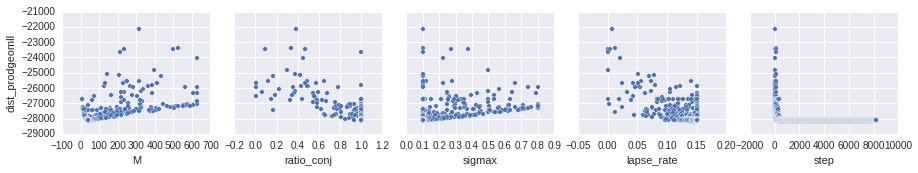

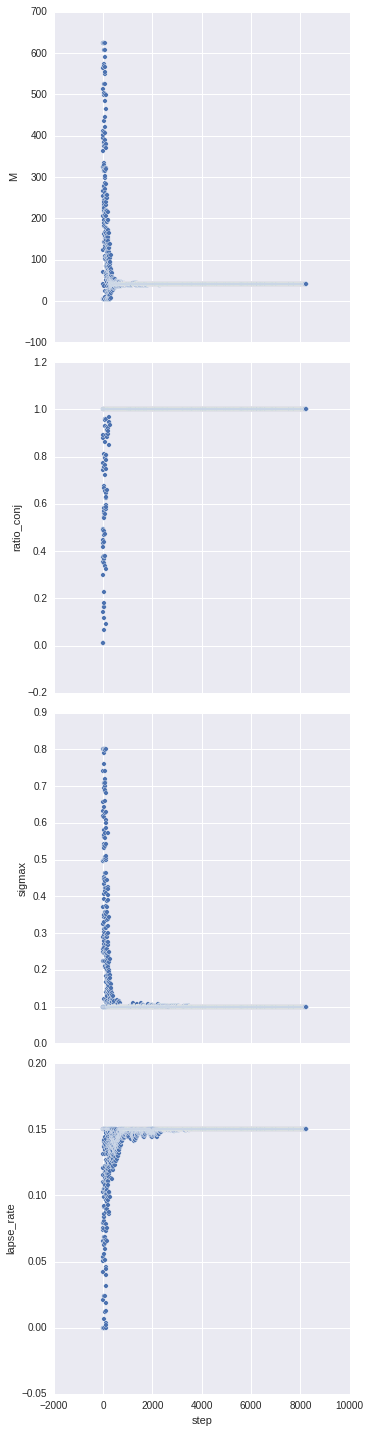

In [11]:
# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'step'],
             y_vars=['dist_prodgeomll']
            )

# Check learning
sns.pairplot(df_best_fits,
             y_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate'],
             x_vars=['step'],
             size=5
            )

## Plotly Scatter3D

In [12]:
df_best_fits.columns

Index([u'step', u'ratio_conj', u'M', u'sigmax', u'lapse_rate',
       u'dist_prodgeomll'],
      dtype='object')

In [13]:
result_to_color = np.array(df_best_fits.dist_prodgeomll)

col_min = np.min(result_to_color)
col_max = np.max(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = Scatter3d(
        x= df_best_fits.M,
        y= df_best_fits.ratio_conj,
        z= df_best_fits.sigmax,
        text= text,
        mode= 'markers',
        marker= Marker(
            color = result_to_color,
            size = 7,
            colorscale='Bluered',
            cmin=col_min,
            cmax=col_max,
            cauto=False
        )
    )
data = Data([trace1])
layout = Layout(
    title='Landscape for NLL90',
    scene=Scene(
        xaxis=XAxis(
            title='M',
        ),
        yaxis=YAxis(
            title='ratio_conj',
        ),
        zaxis=ZAxis(
            title='sigmax',
        )
    )
)
fig = Figure(data=data, layout=layout)
scatter3d_url = py.plot(fig)

In [14]:
dropdown_space = parameter_names_sorted
dropdown_default = 'lapse_rate'
metric_color_space = ['dist_prodgeomll']
metric_color_default = 'dist_prodgeomll'

g = GraphWidget(scatter3d_url)

class shifter:
    def __init__(self):
        self.slider_index = 0
        self.marker_size = 8
        self.filter_results = slice(None, None)
        self.metric_color = metric_color_default
        self.dropdown_value = dropdown_default
        
        self.change_color_source(metric_color_default)
        self.change_dropdown_value(dropdown_default)
    
    def change_dropdown_value(self, new_value):
        self.dropdown_value = new_value
        
        # Update the axes
        self.axes_parameters = dropdown_space[:]
        self.axes_parameters.remove(self.dropdown_value)
        
        # Update the grid of the dropdown parameter
        self.dropparam_gridified, self.dropparam_gridspace, self.dropparam_midspace = utils.gridify(df_best_fits[self.dropdown_value], bins=10)
        
        
    
    def change_color_source(self, new_value):
        self.metric_color = new_value
        self.result_to_color = np.array(df_best_fits[self.metric_color])
        self.result_to_color[self.result_to_color > 2*np.median(self.result_to_color)] = np.median(self.result_to_color)
        self.col_min = np.min(self.result_to_color)
        self.col_max = np.max(self.result_to_color)
    
    def on_color_source_change(self, name, old_value, new_value):
        self.change_color_source(new_value)
        self.replot()
    
    def on_dropdown_change(self, name, old_value, new_value):
        self.change_dropdown_value(new_value)
        p_slider.description='%s [all]' % self.dropdown_value
        self.replot()
    
    def on_slider_change(self, name, old_value, new_value):
        self.slider_index = new_value
        
        if self.slider_index > -1:
            self.filter_results = self.dropparam_gridified[self.slider_index]
            self.marker_size = 6
            p_slider.description='%s [%f]' % (self.dropdown_value, self.dropparam_gridspace[self.slider_index])
        else:
            self.filter_results = slice(None, None)
            self.marker_size = 6
            p_slider.description='%s [all]' % self.dropdown_value
        
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        self.replot()
        
    def replot(self):
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        new_trace = Scatter3d(
            x= df_best_fits[self.axes_parameters[0]][self.filter_results],
            y= df_best_fits[self.axes_parameters[1]][self.filter_results],
            z= df_best_fits[self.axes_parameters[2]][self.filter_results],
            text= self.text,
            mode= 'markers',
            marker= Marker(
                color = self.result_to_color[self.filter_results],
                size = self.marker_size,
                colorscale='Bluered',
                cmin=self.col_min,
                cmax=self.col_max,
                cauto=False
            )
        )
        g.restyle({'x': [[]], 'y': [[]], 'z': [[]], 'marker':None, })
        g.relayout({'title' : "Landscape for %s" % self.metric_color,
                    'scene.xaxis.title': self.axes_parameters[0],
                    'scene.yaxis.title': self.axes_parameters[1],
                    'scene.zaxis.title': self.axes_parameters[2],
                    })
        g.add_traces(new_trace)

p_state = shifter()
p_metric_drop = widgets.Dropdown(description='Metric for color', options=metric_color_space, value=metric_color_default)
p_variable_drop = widgets.Dropdown(description='Variable to slide', options=dropdown_space, value=dropdown_default)
p_slider = widgets.IntSlider(min=-1, max=p_state.dropparam_midspace.size-1, value=-1)
p_slider.description='%s [all]' % p_state.dropdown_value

p_slider.on_trait_change(p_state.on_slider_change, 'value')
p_variable_drop.on_trait_change(p_state.on_dropdown_change, 'value')
p_metric_drop.on_trait_change(p_state.on_color_source_change, 'value')

p_state.replot()

In [15]:
display(p_metric_drop)
display(p_variable_drop)
display(p_slider)
display(g)

## Check parameters values obtained

In [16]:
df_bestparams = df_best_fits.sort('step', ascending=False).iloc[0]
df_bestparams

step                8219.000000
ratio_conj             1.000000
M                     40.920215
sigmax                 0.100000
lapse_rate             0.150000
dist_prodgeomll   -28127.835306
Name: 8219, dtype: float64

In [17]:
%env WORKDIR_DROP

'/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory'

In [18]:
%run /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/experimentlauncher.py \
--action_to_do launcher_do_fitexperiment_allmetrics --inference_method none  --num_samples 200  --renormalize_sigmax --autoset_parameters --code_type mixed  --sigmay 0.00001  --experiment_id bays09  \
--lapse_rate {df_bestparams['lapse_rate']} --M {int(df_bestparams['M'])} --sigmax {df_bestparams['sigmax']} --ratio_conj {df_bestparams['ratio_conj']}

Arguments: ['--action_to_do', 'launcher_do_fitexperiment_allmetrics', '--inference_method', 'none', '--num_samples', '200', '--renormalize_sigmax', '--autoset_parameters', '--code_type', 'mixed', '--sigmay', '0.00001', '--experiment_id', 'bays09', '--lapse_rate', '0.15', '--M', '40', '--sigmax', '0.1', '--ratio_conj', '1.0']

        Given a single experiment_id, will run the model on all T in the experimental data.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperimentsinglet
{'M_layer_one': 400, 'action_to_do': 'launcher_do_fitexperiment_allmetrics', 'code_type': 'mixed', 'renormalize_sigmax': True, 'selection_num_samples': 1, 'sigma_output': 0.0, 'job_action': 'launcher_do_simple_run', 'subaction': '', 'load_all_from_para

True angles: -2.424 | -3.023 | -0.230 | 0.251 | 2.643 | 2.665 >> Inferred: -2.036 | 2.878 | 2.702 | 2.727 | 2.689 | 2.677


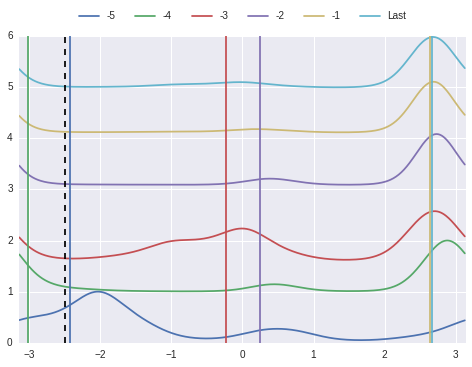

In [43]:
fit_exp.setup_experimental_stimuli_T(6)
fit_exp.sampler.plot_likelihood_correctlycuedtimes(n=0, should_exponentiate=True)

T 1

>>> Setting up 1 nitems, 1800 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 1.0 conj: 40, feat: 0, autoset: 1
sigmax/max network: 0.10000
sigmax/max network: 0.10000
-> init theta, feature 1 cued, time 1
Likelihood cued
True angles: 2.108 >> Inferred: 2.174


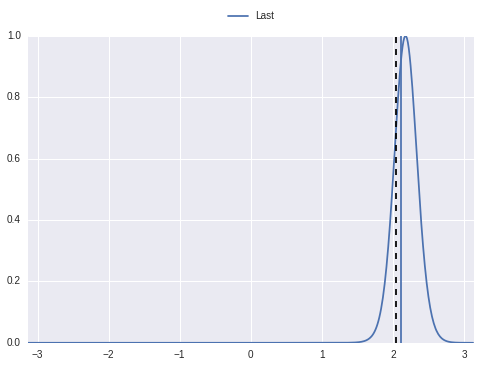

Histogram errors
T 2

>>> Setting up 2 nitems, 1800 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 1.0 conj: 40, feat: 0, autoset: 1
sigmax/max network: 0.10000
sigmax/max network: 0.10000
-> init theta, feature 1 cued, time 1
Likelihood cued
True angles: -1.455 | -2.132 >> Inferred: -1.583 | -2.325


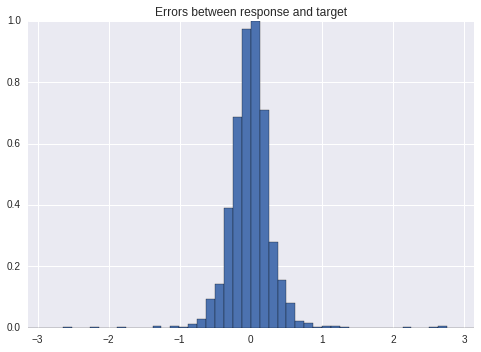

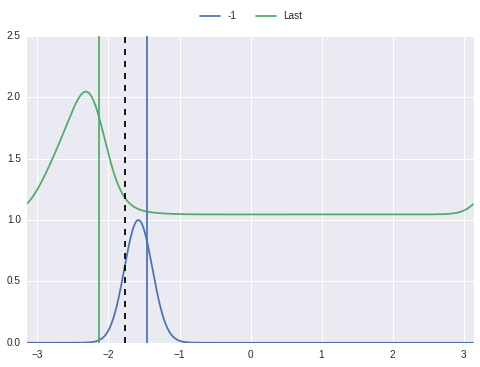

Histogram errors
Histogram non targets
mu: 0.722, kappa: 0.053
{'R': 47.847598375157126, 'u': 1.1969366244128883, 'pvalue': 0.11566562882656051, 'V': 35.908098732386648}
mu: 0.722, kappa: 0.053
T 4

>>> Setting up 4 nitems, 1800 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 1.0 conj: 40, feat: 0, autoset: 1
sigmax/max network: 0.10000
sigmax/max network: 0.10000
-> init theta, feature 1 cued, time 1
Likelihood cued
True angles: -0.845 | 2.985 | 2.633 | 2.103 >> Inferred: 2.551 | 2.777 | 2.652 | 2.626


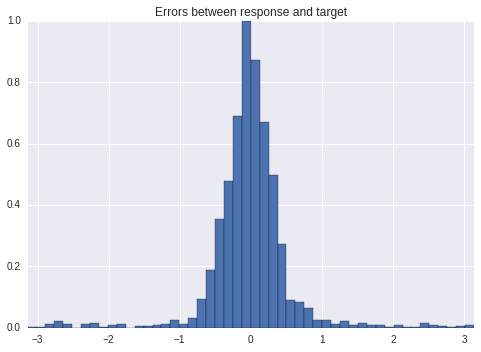

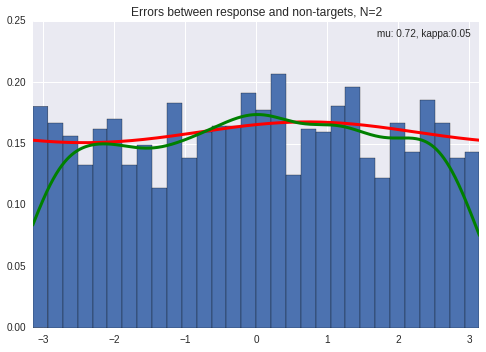

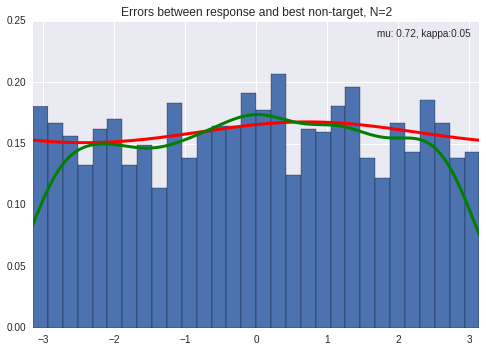

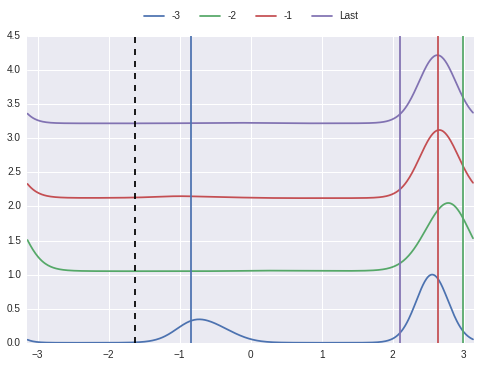

Histogram errors
Histogram non targets
mu: 0.015, kappa: 0.092
{'R': 248.10638079435915, 'u': 4.7742636549007882, 'pvalue': 9.0182980683195524e-07, 'V': 248.07801657052948}
mu: 0.014, kappa: 1.851
T 6

>>> Setting up 6 nitems, 1800 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 1.0 conj: 40, feat: 0, autoset: 1
sigmax/max network: 0.10000
sigmax/max network: 0.10000
-> init theta, feature 1 cued, time 1
Likelihood cued
True angles: 0.537 | 1.776 | -2.223 | -2.834 | -1.358 | -0.129 >> Inferred: -2.036 | 1.458 | -1.985 | -2.576 | -1.973 | 1.382


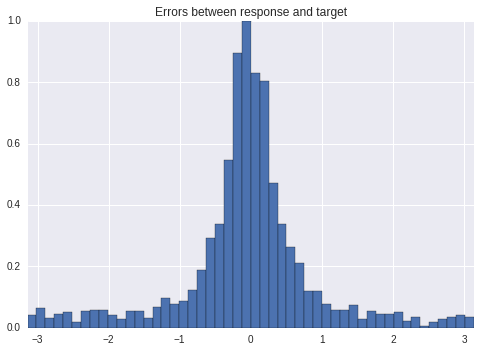

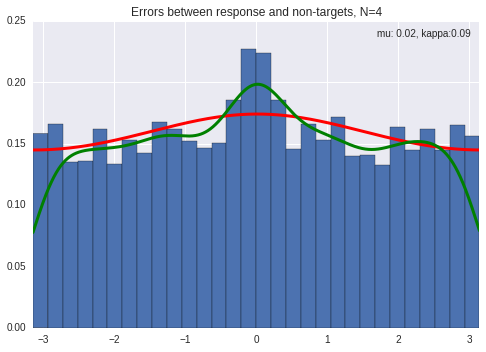

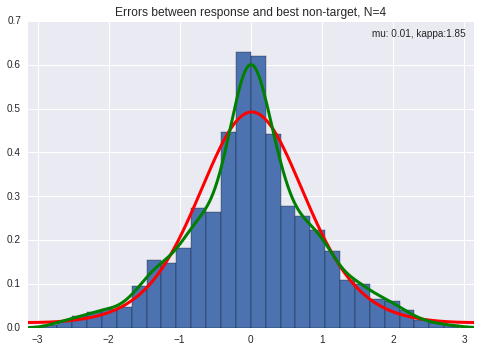

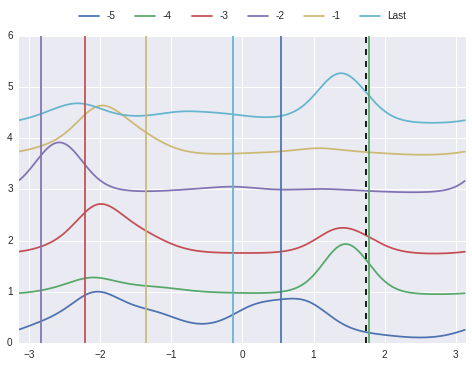

Histogram errors
Histogram non targets
mu: 0.120, kappa: 0.116
{'R': 522.44726559352932, 'u': 7.7324482996070438, 'pvalue': 5.3290705182007514e-15, 'V': 518.70840091272032}
mu: -0.002, kappa: 3.953


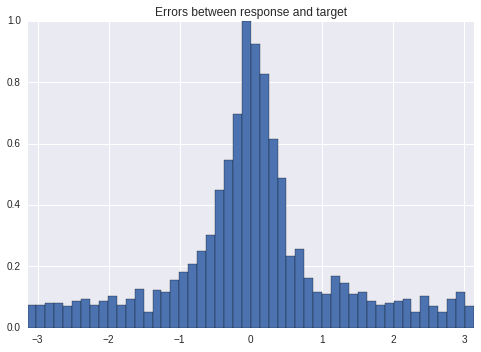

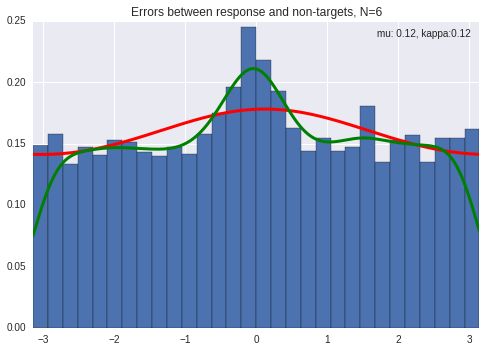

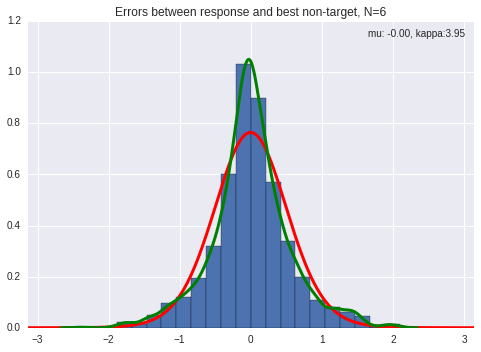

In [44]:
## This is the data, I think

for T in [1, 2, 4, 6]:
    print "T %d" % T
    fit_exp.setup_experimental_stimuli_T(T)
    
    print "Likelihood cued"
    fit_exp.sampler.plot_likelihood_correctlycuedtimes(n=1, should_exponentiate=True)

    print "Histogram errors"
    fit_exp.sampler.plot_histogram_errors(bins=51)
    
    if fit_exp.sampler.T > 1:
        print "Histogram non targets"
        fit_exp.sampler.plot_histogram_bias_nontarget()

MODEL T 1

>>> Setting up 1 nitems, 1800 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 1.0 conj: 40, feat: 0, autoset: 1
sigmax/max network: 0.10000
sigmax/max network: 0.10000
-> init theta, feature 1 cued, time 1
resampling...
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -168.02
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 06.03 23:33                                                     
Loglikelihood: -265.63
top 90% loglike: -78.89
MODEL Likelihood cued
True angles: 2.108 >> Inferred: 2.124


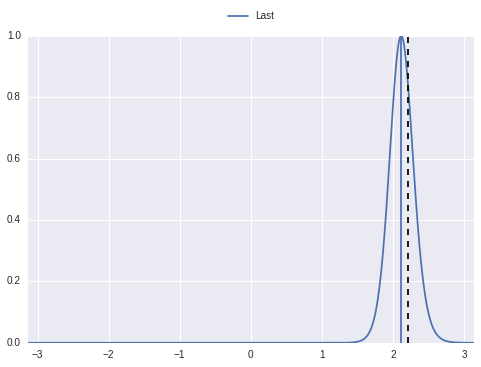

MODEL Histogram errors
MODEL T 2

>>> Setting up 2 nitems, 1800 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 1.0 conj: 40, feat: 0, autoset: 1
sigmax/max network: 0.10000
sigmax/max network: 0.10000
-> init theta, feature 1 cued, time 1
resampling...
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -395.83
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 06.03 23:35                                                     
Loglikelihood: -439.47
top 90% loglike: -253.22
MODEL Likelihood cued
True angles: -1.455 | -2.132 >> Inferred: -1.181 | -2.714


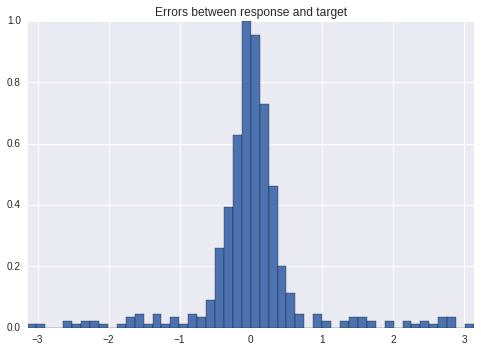

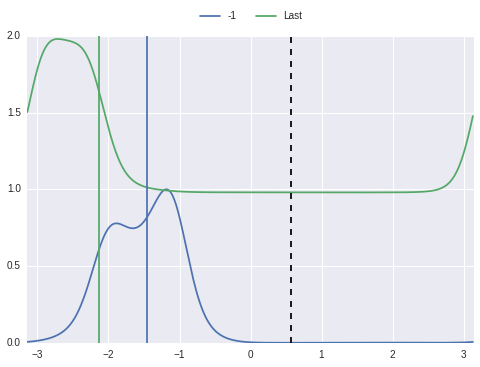

MODEL Histogram errors
MODEL Histogram non targets
mu: -0.208, kappa: 0.189
{'R': 47.03599047230567, 'u': 2.9105248723376205, 'pvalue': 0.0018041112337003895, 'V': 46.019438915788413}
mu: -0.208, kappa: 0.189
MODEL T 4

>>> Setting up 4 nitems, 1800 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 1.0 conj: 40, feat: 0, autoset: 1
sigmax/max network: 0.10000
sigmax/max network: 0.10000
-> init theta, feature 1 cued, time 1
resampling...
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -675.64
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 06.03 23:37                                                     
Loglikelihood: -513.87
top 90% loglike: -348.44
MODEL Likelihood cued
True angles: -0.845 | 2.985 | 2.633 | 2.103 >> Inferred: -0.792 | 2.526 | 2.438 | 2.249


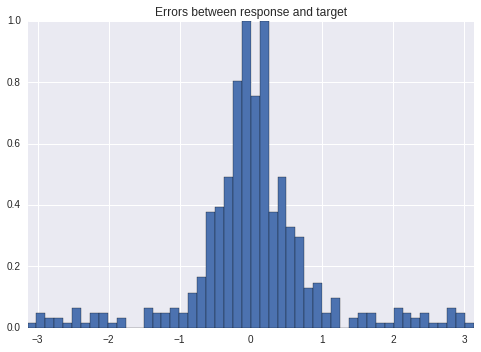

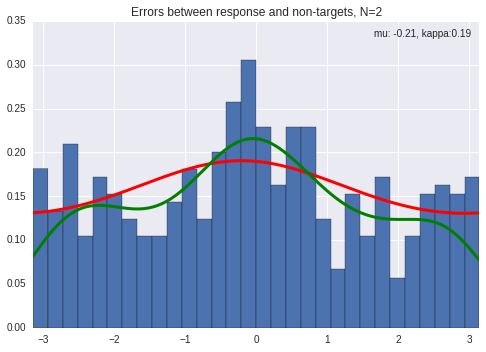

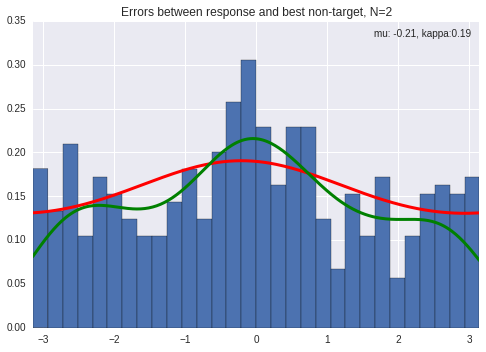

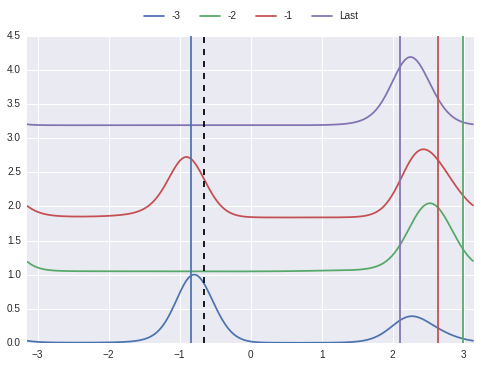

MODEL Histogram errors
MODEL Histogram non targets
mu: 0.369, kappa: 0.115
{'R': 85.812701378622862, 'u': 2.9221746527765555, 'pvalue': 0.0017379828175921874, 'V': 80.027048714777294}
mu: 0.067, kappa: 1.893
MODEL T 6

>>> Setting up 6 nitems, 1800 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 1.0 conj: 40, feat: 0, autoset: 1
sigmax/max network: 0.10000
sigmax/max network: 0.10000
-> init theta, feature 1 cued, time 1
resampling...
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -821.87
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 06.03 23:39                                                     
Loglikelihood: -642.24
top 90% loglike: -479.70
MODEL Likelihood cued
True angles: 0.537 | 1.776 | -2.223 | -2.834 | -1.358 | -0.129 >> Inferred: -1.144 | 1.370 | -0.691 | 2.589 | -1.960 | -2.086


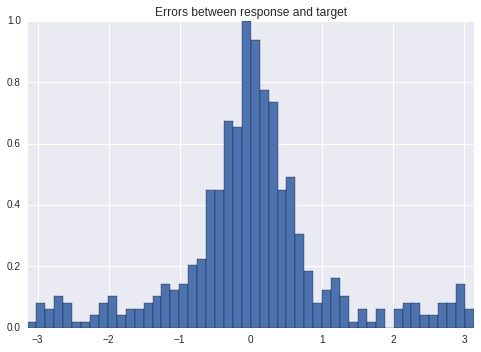

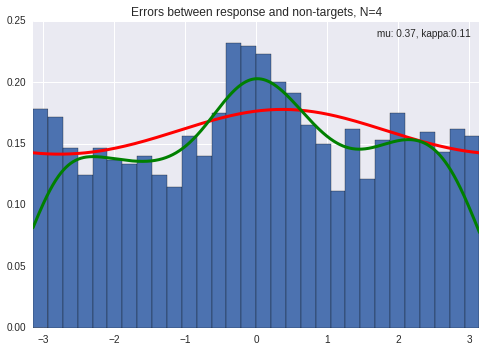

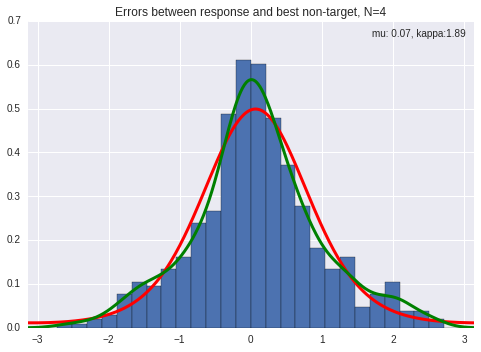

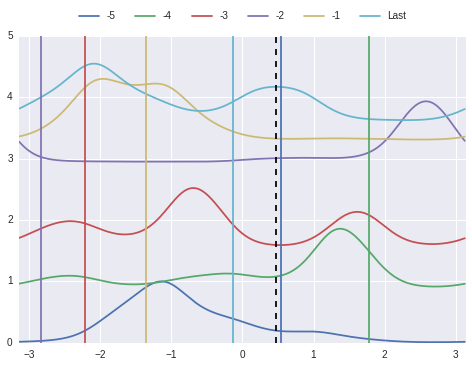

MODEL Histogram errors
MODEL Histogram non targets
mu: 0.023, kappa: 0.152
{'R': 188.88006182898636, 'u': 5.3409832000196493, 'pvalue': 4.6221912075594673e-08, 'V': 188.83227194686603}
mu: 0.037, kappa: 4.019


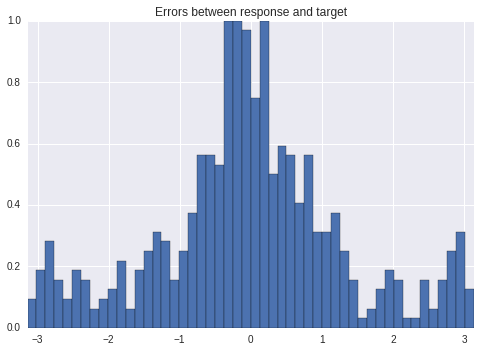

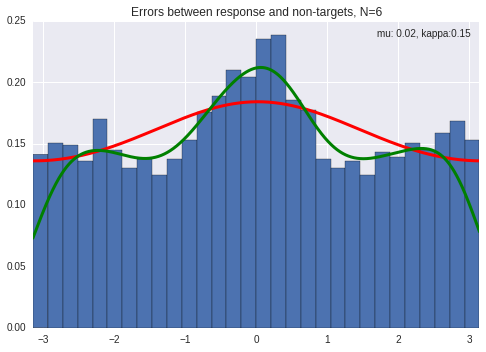

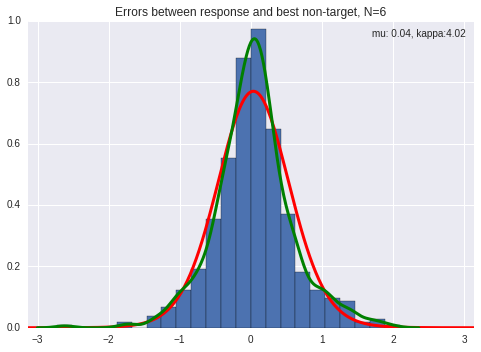

In [19]:
# Force resampling
for T in [1, 2, 4, 6]:
    print "MODEL T %d" % T
    fit_exp.setup_experimental_stimuli_T(T)
    # Only use small subset of N
    fit_exp.sampler.N = 500
    
    print 'resampling...'
    fit_exp.sampler.force_sampling_round()
    
    print "MODEL Likelihood cued"
    fit_exp.sampler.plot_likelihood_correctlycuedtimes(n=1, should_exponentiate=True)

    print "MODEL Histogram errors"
    fit_exp.sampler.plot_histogram_errors(bins=51)
    
    if fit_exp.sampler.T > 1:
        print "MODEL Histogram non targets"
        fit_exp.sampler.plot_histogram_bias_nontarget()
        

In [ ]:
self.data_gen.nontargets_indices.shape